In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import zipfile
import numpy as np
import re

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True) # initiate notebook for offline plot 

In [11]:
# Load unclean data
zf = zipfile.ZipFile("/mnt/c/Users/pl199/Downloads/Avito_Data/train.csv.zip") 
train_data = pd.read_csv(zf.open("train.csv"))

zf = zipfile.ZipFile("/mnt/c/Users/pl199/Downloads/Avito_Data/test.csv.zip") 
test_data = pd.read_csv(zf.open("test.csv"))

In [12]:
# Load clean data
zf = zipfile.ZipFile("/mnt/c/Users/pl199/Downloads/Avito_Data/clean.csv.zip") 
clean_data = pd.read_csv(zf.open("clean.csv"))

In [13]:
# Get a series of prices (Keep ordering same as how clean.csv formed)
prices = pd.concat([train_data["price"],test_data["price"]], axis=0)
# Add prices series to data
clean_data =  clean_data.assign(price=prices.values)

### Price observations  ###

In [14]:
pc = pd.read_csv("/mnt/c/Users/pl199/Downloads/Avito_Data/parent_category_names.csv")
c = pd.read_csv("/mnt/c/Users/pl199/Downloads/Avito_Data/category_names.csv")

pcDict = pc.set_index("Russian").to_dict()["English"]
cDict = c.set_index("Russian").to_dict()["English"]

In [15]:
grouped = clean_data.groupby(["parent_category_name","category_name"])
# Each chunks is a grouping of data w/ same (parent_category_name, category_name)
chunks = [grouped.get_group(x) for x in grouped.groups]
chunks.sort(key=lambda x: x.shape[0])

In [187]:
gNum = 4
print("Praent Category: " + pcDict[chunks[gNum].iloc[0]["parent_category_name"]])
print("Category: " + cDict[chunks[gNum].iloc[0]["category_name"]])
data = go.Histogram(x=chunks[gNum]["price"])
iplot([data], filename='histogram')

Praent Category: Hobbies and Recreation
Category: Hunting and fishing


In [188]:
grouped = train_data.groupby(["parent_category_name","category_name"]) # Always going to group by (parent_category,catorgory)
chunks = [grouped.get_group(x) for x in grouped.groups]

N = gNum

p = chunks[N]["price"].values
nanBool1 = np.isnan(p)

zI = np.where(p==0)[0]
zBool = np.zeros(chunks[N].shape[0], dtype=bool)
zBool[zI] = True

dp = chunks[N]["deal_probability"].values
nanBool2 = np.isnan(dp)

p = p[~nanBool1 & ~nanBool2 & ~zBool]
dp = dp[~nanBool1 & ~nanBool2 & ~zBool]

# Feature-scale prices 
p = (p - p.min()) / (p.max() - p.min())
dp = (dp - dp.min()) / (dp.max() - dp.min())

features = np.concatenate((p[np.newaxis].T,dp[np.newaxis].T),axis=1)

In [189]:
# Observe specific points (Code here(Vs below) for convenience)
m = chunks[gNum]["price"].nlargest(3).index
print(chunks[gNum].loc[m])

# For punctuation 
import string
count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))

# Len of descriptions
counter = 0
for each in m:
    test = chunks[gNum].loc[each]["description"]
    top = float(count(test,string.punctuation))
    bot = len(test)
    print(str(counter) + " : " + str(bot))
    counter += 1

              item_id       user_id                   region         city  \
645665   c82e6a5f3c5e  d28f79b9c231    Новосибирская область  Новосибирск   
1347413  1cb937a3cca2  58d80253ba64         Тульская область         Тула   
1034386  65aa0d7e9ba2  3c96a0cf451e  Калининградская область  Калининград   

        parent_category_name    category_name param_1 param_2 param_3  \
645665         Хобби и отдых  Охота и рыбалка     NaN     NaN     NaN   
1347413        Хобби и отдых  Охота и рыбалка     NaN     NaN     NaN   
1034386        Хобби и отдых  Охота и рыбалка     NaN     NaN     NaN   

                                            title  \
645665                          Лампа керосиновая   
1347413  Катер "Прогресс-4М" с мотором "Ямаха-40"   
1034386                       Pulsar Quantum XD50   

                                               description     price  \
645665   керосиновые лампы с консервации .. 1957-1967 г...  400500.0   
1347413  Продаю катер "Прогресс-4М" с мот

In [190]:
from sklearn.cluster import KMeans

In [191]:
kmeans = KMeans(n_clusters=4).fit_predict(features)

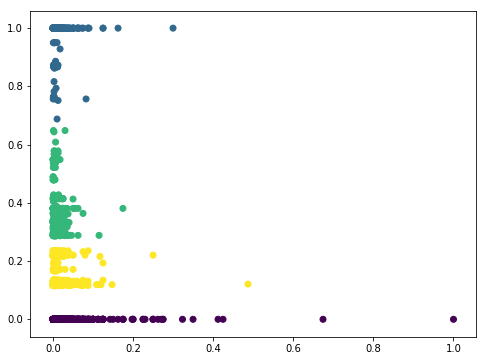

In [192]:
plt.figure(figsize=(8, 6))
plt.scatter(features[:,0], features[:,1], c=kmeans.astype(float))

In [193]:
# Modified z-score

pOrig = chunks[N]["price"].values
nanBool = np.isnan(pOrig)

pOrig = pOrig[~nanBool] # Without Nan
p = pOrig + (10.0)**-9
p = np.log(p)

# Modified z-score (Only look at price)
thresh = 3.5
median = np.median(p)

median_absolute_deviation = np.median(np.abs(p-median))

modified_z_scores = 0.6745*(p - median) / median_absolute_deviation

bad = np.where(np.abs(modified_z_scores) > thresh)

toPlot = np.zeros(p.size)
toPlot[bad[0]] = 1.0
print(bad[0].size) 
print(p.size- bad[0].size)

36
4320


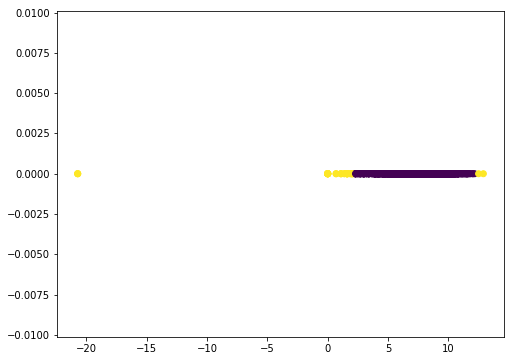

In [195]:
plt.figure(figsize=(8, 6))
plt.scatter(p,np.zeros(toPlot.size), c=toPlot)

### Tag words ###

In [7]:
# Need item_id for training data as clean contains both training and testing data
zf = zipfile.ZipFile('/mnt/c/Users/pl199/Downloads/Avito_Data/train.csv.zip')
for_id = pd.read_csv(zf.open('train.csv'))

# Read in cleaned text
zf = zipfile.ZipFile('/mnt/c/Users/pl199/Downloads/Avito_Data/clean.csv.zip')
clean_data = pd.read_csv(zf.open('clean.csv'))

train_id = for_id["item_id"].values
train_data = clean_data[clean_data["item_id"].isin(train_id)]
test_data = clean_data[~clean_data["item_id"].isin(train_id)]

In [8]:
# Get english words & frequncies
chunk_dicts = [] # Array of dictionaries (1 per group)
word_freq = {} # word -> frequency  

grouped = train_data.groupby(["parent_category_name","category_name"])
chunks = [grouped.get_group(x) for x in grouped.groups] # Each chunks is a grouping of data w/ same (parent_category_name, category_name)


for chunk in chunks:
    word_map = {} # word -> List of item_ids

    for _,row in chunk.iterrows():
        
        word_soup = row["merged"]
        word_salad = word_soup.split()
        
        for word in set(word_salad): 
            
            # If string and english text (Everything should be lowercase)
            if type(word) is str and  re.match(r"([a-z]+)$", word) != None:
                
                if word not in word_map:
                    word_map[word] = []
                
                if word not in word_freq: 
                    word_freq[word] = 0
                
                word_map[word].append(row["item_id"])
                word_freq[word] += 1
                
    chunk_dicts.append(word_map)

m 54874
median:70.0
[234, 7, 3233, 279, 119, 7, 3, 70, 7, 1513, 30, 411, 16, 89, 5, 81, 60, 262, 5, 1, 266, 8, 1434, 11, 15, 4, 521, 1, 188, 138, 29, 173, 33, 108, 279, 592, 1, 42624, 1678, 53, 4, 2, 280]
a 15893
median:105.0
[945, 7, 1038, 332, 145, 15, 12, 41, 17, 1751, 21, 130, 105, 36, 7, 111, 164, 1213, 5, 3, 825, 2, 264, 4, 44, 34, 784, 1, 380, 314, 63, 107, 8, 157, 1164, 380, 247, 4852, 42, 1, 2, 5, 115]
d 11853
median:91.0
[56, 33, 430, 891, 122, 5, 10, 91, 3, 2308, 25, 179, 91, 52, 8, 86, 97, 228, 10, 4, 237, 8, 91, 16, 180, 14, 1103, 1185, 200, 540, 161, 1, 1, 25, 440, 370, 349, 327, 1429, 114, 7, 13, 9, 304]
y 901
median:5.5
[9, 72, 22, 4, 2, 94, 2, 9, 5, 2, 8, 5, 15, 1, 23, 1, 42, 2, 5, 2, 42, 4, 38, 5, 6, 3, 43, 107, 4, 70, 218, 2, 1, 33]
j 1950
median:15.5
[10, 1, 90, 38, 20, 3, 123, 6, 13, 2, 1, 26, 14, 111, 1, 18, 33, 1, 3, 3, 127, 16, 32, 8, 24, 1, 9, 50, 15, 54, 1046, 29, 1, 21]
o 589
median:7.0
[1, 4, 17, 19, 34, 2, 1, 7, 5, 68, 7, 6, 5, 4, 2, 8, 8, 12, 2, 1, 5, 4, 3

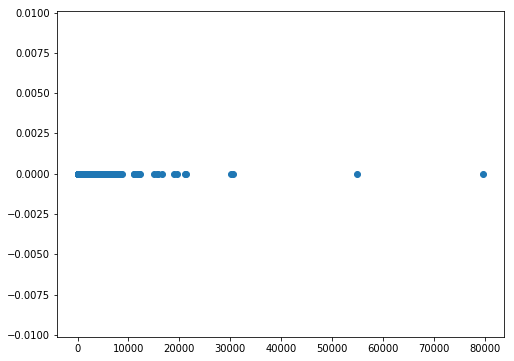

In [9]:
N = 0 # Which category

# Remember:
# chunks_dict[N] -> Dict of a specific chunk with word keys len(ks_dict[N][word]) -> Freq of word
# word_freq -> Total frequency of a word

# Test 0 - How many 1 letter words?
for word in word_freq:
    if len(word) < 2:
        print(word + " " + str(word_freq[word]))
        test = []
        for c in chunk_dicts:
            if word in c:
                test.append(len(c[word]))
        print("median:" + str(np.median(np.array(test))))
        print(test)

# Test 1 - General visualization of frequency
plt.figure(figsize=(8, 6))
plt.scatter(np.array(list(word_freq.values())),np.zeros(len(word_freq)))

5044


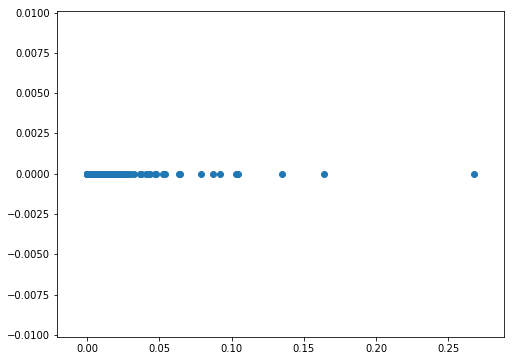

<Figure size 576x432 with 0 Axes>

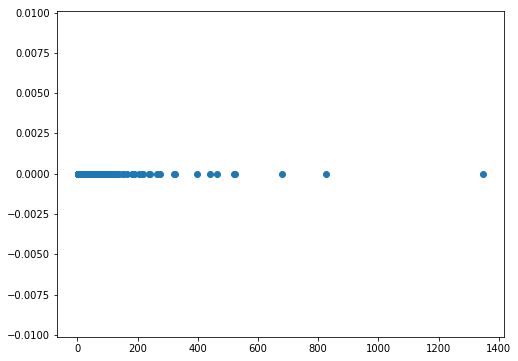

In [10]:
# Remember:
# chunks_dict[N] -> Dict of a specific chunk with word keys len(ks_dict[N][word]) -> Freq of word
# word_freq -> Total frequency of a word

# Test 2 - word frequency plotting
N = 20
pcwf = []
unique_ids = []
for word in chunk_dicts[N]:
    pcwf.append(len(chunk_dicts[N][word]))
    unique_ids += chunk_dicts[N][word]

pcwf = np.array(pcwf)
id_len = len(set(unique_ids))
print(id_len)

plt.figure(figsize=(8, 6))
plt.scatter(pcwf/id_len,np.zeros(len(pcwf)))
plt.figure(figsize=(8, 6))

plt.figure(figsize=(8, 6))
plt.scatter(pcwf,np.zeros(len(pcwf)))

Praent Category: Hobbies and Recreation
Category: Tickets and travel


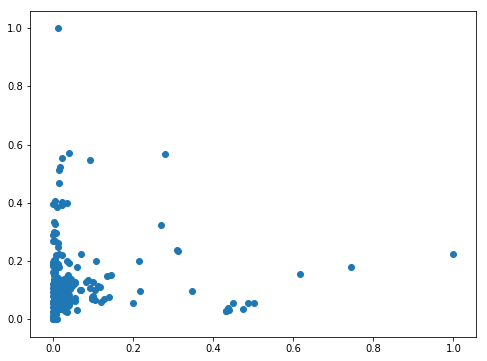

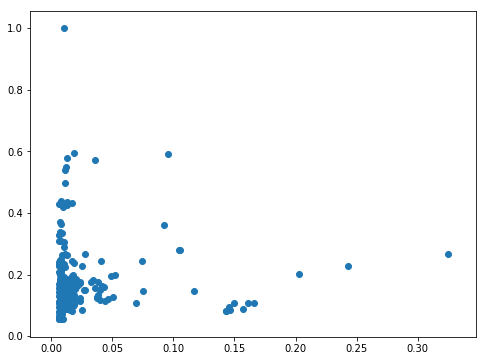

In [73]:
# Test 3 - 2 dimensions (Importance vs Frequency)
N =5

id_freq = {}
freq = []
imp = []

# Let's remove anything below median(50% of words) - Added in after looking at graph - Seems like a lot have low frequency
# Doesn't really help us build a general model
initial = []

for word in chunk_dicts[N]:
    initial.append((len(chunk_dicts[N][word]),word))

sorted_words = [drop for _,drop in sorted(initial)]

for word in sorted_words[:int(len(sorted_words)*0.9)]: # 50 percent of words (1/2 of list)
    chunk_dicts[N].pop(word,None)


for word in topop:
    chunk_dicts[N].pop(word, None)

# Calculate number of tags each item has
for word in chunk_dicts[N]:
    for item_id in chunk_dicts[N][word]:
        if item_id not in id_freq:
            id_freq[item_id] = 0
        id_freq[item_id] += 1

# Get frequency and importance metrics for each word
for word in chunk_dicts[N]:
    freq.append(len(chunk_dicts[N][word]))
    temp = 0.0
    
    for item_id in chunk_dicts[N][word]:
        temp += 1.0/(id_freq[item_id])
        
    imp.append(temp/len(chunk_dicts[N][word]))

    
# Scale that shit
freq = np.array(freq)
imp = np.array(imp)

# Min/Max scaling
min_freq = np.amin(freq)
max_freq = np.amax(freq)
freq_normal = (freq - min_freq)/(max_freq - min_freq)

min_imp = np.amin(imp)
max_imp = np.amax(imp)
imp_normal = (imp - min_imp)/(max_imp - min_imp)

# Fun print
pc = pd.read_csv("/mnt/c/Users/pl199/Downloads/Avito_Data/parent_category_names.csv")
c = pd.read_csv("/mnt/c/Users/pl199/Downloads/Avito_Data/category_names.csv")

pcDict = pc.set_index("Russian").to_dict()["English"]
cDict = c.set_index("Russian").to_dict()["English"]

print("Praent Category: " + pcDict[chunks[N].iloc[0]["parent_category_name"]])
print("Category: " + cDict[chunks[N].iloc[0]["category_name"]])

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(freq_normal,imp_normal)

plt.figure(figsize=(8, 6))
plt.scatter(freq/len(id_freq),imp)

In [ ]:
# So test 3 isn't necessarily a valid approach
# By that -> Might not actually get great results 
# What is your goal?: -> To get tags (Lets limit the number to 5 per subcat)
# Goal: leaves contain as few points as possible

# Problem with freq is that u can get tags that are repeating information (Little info gain from the actual tag)
# Overlapping freq

